If you are not running this notebook in Colar already, and would like to, click the button below:

<a href="https://colab.research.google.com/github/tudaga/interactive_gene_plots/blob/master/Interactive_plots_scRNAseq_Slideseq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys, subprocess, shutil
IN_COLAB = 'google.colab' in sys.modules
print('Using colab?: {}'.format(IN_COLAB))

if IN_COLAB:
    # increase the RAM
    l=[]
    while 1:
      l.append('nothing')

Using colab?: False


Wait for a few moments and when the message appears at the bottom of the colab window, click on "Get more RAM".

In [2]:
import sys, subprocess, shutil
IN_COLAB = 'google.colab' in sys.modules
print('Using colab?: {}'.format(IN_COLAB))
def run_cmd(cmd):
    print('Output of "{}":'.format(cmd))
    print(subprocess.run(cmd,stdout=subprocess.PIPE, shell=True).stdout.decode('utf-8'))
REPO_NAME = 'interactive_gene_plots'
GITHUB_REPO = f'https://github.com/tudaga/{REPO_NAME}'

if IN_COLAB:
    run_cmd('sudo apt-get install git-lfs')
    run_cmd('git lfs install')
    run_cmd(f'rm -rf {REPO_NAME}')
    run_cmd(f'git clone --verbose --progress {GITHUB_REPO}')
    run_cmd(f'cd {REPO_NAME} && git lfs pull && cd ..')
    run_cmd(f'mv {REPO_NAME}/* .')
    run_cmd(f'rm -r {REPO_NAME}')

Using colab?: False


## Imports

In [3]:
!pip install scanpy
!pip install leidenalg
!pip install cmake
!pip install MulticoreTSNE

In [4]:
from __future__ import print_function
from ipywidgets import interact, IntSlider
from ipywidgets import FloatSlider
import ipywidgets as widgets
import pandas as pd
import numpy as np
np.random.seed(8)
%matplotlib inline
import matplotlib.pyplot as plt
import scanpy as sc
import altair as alt
#alt.renderers.enable('altair_viewer')
alt.renderers.enable('html')
alt.data_transformers.disable_max_rows()
from tqdm import tqdm
import os

/home/agoeva/anaconda3/envs/slideseq/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [5]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## Read Slide-seq puck data

There is a separate preprocessing notebook `Puck_190926_11_Preprocessing.ipynb` 
that converts the original Slide-seq data files MappedDGEForR.csv and BeadLocationsForR.csv 
into counts.csv and coords.csv. 
Note that the full data is too large to fit into colab, so we filter out beads with less than 
300 UMIs for the purposes of the colab example.

In [6]:
puck_name = '190926_11'
if IN_COLAB:
    coords_df = pd.read_csv(f"data/Puck_{puck_name}/coords_gr300.csv")
    counts_df = pd.read_csv(f"data/Puck_{puck_name}/counts_gr300.csv")
else:
    coords_df = pd.read_csv(f"data/Puck_{puck_name}/coords.csv")
    counts_df = pd.read_csv(f"data/Puck_{puck_name}/counts.csv")

In [7]:
print(coords_df.shape)
coords_df.head()

(43547, 3)


barcode            x            y
0  AATCAACTTTTTTT  3848.023256  1205.232558
1  CAACCGTGGTTTTC  4515.945055  4332.978022
2  GACTGAATAGCTTT  3431.261538  3989.923077
3  CAACAAGTATTGTT  4475.911392  3376.987342
4  GGGCAACTGATCTT  3180.948276  2501.396552

In [8]:
print(counts_df.shape)
counts_df.head()

(43547, 22621)


barcode  0610005C13Rik  0610007P14Rik  0610009B22Rik  0610009E02Rik  \
0  AATCAACTTTTTTT              0              0              0              0   
1  CAACCGTGGTTTTC              0              0              0              0   
2  GACTGAATAGCTTT              0              0              0              0   
3  CAACAAGTATTGTT              0              1              0              0   
4  GGGCAACTGATCTT              0              0              0              0   

   0610009L18Rik  0610009O20Rik  0610010F05Rik  0610010K14Rik  0610011F06Rik  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   ...  mt-Tq  mt-Tr  mt-Ts2  mt-Tt  mt-Tv  n-R5-8s1  n-R5s173  n-R5s25  \
0  ...      0      0       0      0      0         0         0        0   
1  ...      0      0       0      0      0         0         0        0   
2  ...      0      0       0      0      0         0         0        0   
3  ...      0      0       0      0      0         0         0        0   
4  ...      0      0       0      0      0         0         0        0   

   n-R5s29  n-R5s40  
0        0        0  
1        0        0  
2        0        0  
3        0        0  
4        0        0  

[5 rows x 22621 columns]

In [9]:
meta_df = coords_df.merge(counts_df, 
                          right_on='barcode', left_on='barcode')
meta_df.set_index(keys='barcode', drop=True, inplace=True)
print(f"The puck id is {puck_name}.")
print(f"The raw number of beads is {meta_df.shape[0]}.")
print(f"The raw number of genes is {meta_df.shape[1]-2}.")

The puck id is 190926_11.
The raw number of beads is 43547.
The raw number of genes is 22620.


## Put puck into a scanpy object

In [10]:
adata = sc.AnnData(meta_df.drop(['x', 'y'], axis=1))
adata.obs['barcode'] = meta_df.index
adata.raw = adata
spatial = meta_df[['x', 'y']]
adata.obsm['X_spatial'] = spatial.values.astype(np.float32)

The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.


### EDA with scanpy

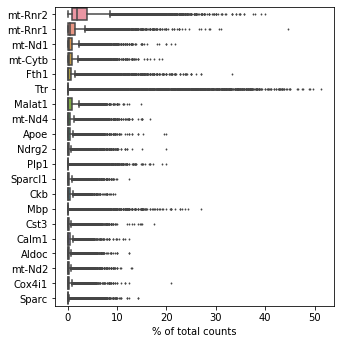

In [11]:
sc.pl.highest_expr_genes(adata, n_top=20)

### Filter beads

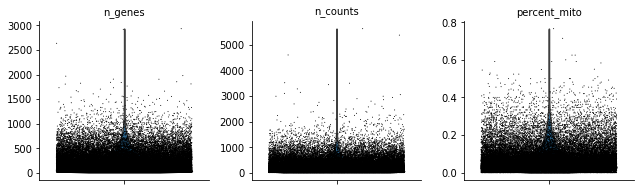

In [12]:
sc.pp.filter_cells(adata, min_genes=1)
mito_genes = adata.var_names.str.startswith('mt-')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, 
                                   axis=1) / np.sum(adata.X, axis=1)
adata.obs['n_counts'] = adata.X.sum(axis=1)
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

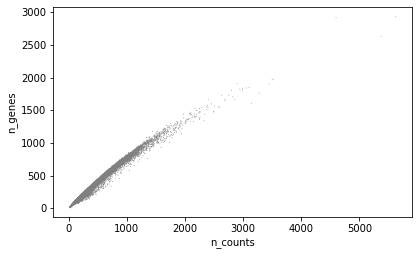

In [13]:
adata = adata[adata.obs['n_genes'] > 1, :]
adata = adata[adata.obs['percent_mito'] < 0.2, :]
sc.pl.scatter(adata, x='n_counts', y='n_genes')

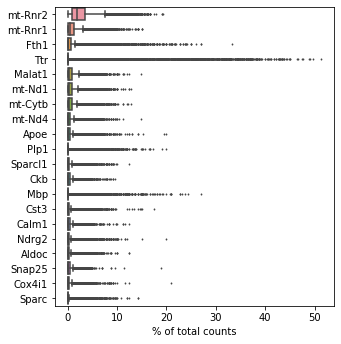

In [14]:
sc.pl.highest_expr_genes(adata, n_top=20)

### Highly variable genes

/home/agoeva/anaconda3/envs/slideseq/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:298: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


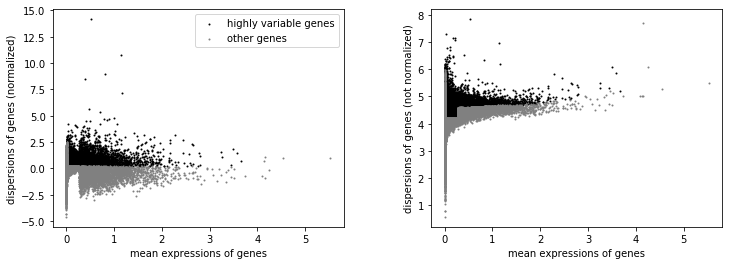

In [15]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata, 
                            min_mean=0.01, max_mean=4, min_disp=0.2)
sc.pl.highly_variable_genes(adata)

In [16]:
counts = meta_df.reset_index('barcode').drop(['x', 'y'], axis=1)
counts = counts.merge(pd.DataFrame(adata.obs['barcode'].index), 
                  left_on='barcode', right_on='barcode')
counts.set_index('barcode', inplace=True)
print(counts.shape)
counts.head()

(41121, 22620)


0610005C13Rik  0610007P14Rik  0610009B22Rik  0610009E02Rik  \
barcode                                                                      
AATCAACTTTTTTT              0              0              0              0   
CAACCGTGGTTTTC              0              0              0              0   
GACTGAATAGCTTT              0              0              0              0   
CAACAAGTATTGTT              0              1              0              0   
CGCAAGTGTCTCTC              0              0              0              0   

                0610009L18Rik  0610009O20Rik  0610010F05Rik  0610010K14Rik  \
barcode                                                                      
AATCAACTTTTTTT              0              0              0              0   
CAACCGTGGTTTTC              0              0              0              0   
GACTGAATAGCTTT              0              0              0              0   
CAACAAGTATTGTT              0              0              0              0   
CGCAAGTGTCTCTC              0              0              0              0   

                0610011F06Rik  0610025J13Rik  ...  mt-Tq  mt-Tr  mt-Ts2  \
barcode                                       ...                         
AATCAACTTTTTTT              0              0  ...      0      0       0   
CAACCGTGGTTTTC              0              0  ...      0      0       0   
GACTGAATAGCTTT              0              0  ...      0      0       0   
CAACAAGTATTGTT              0              0  ...      0      0       0   
CGCAAGTGTCTCTC              0              0  ...      0      0       0   

                mt-Tt  mt-Tv  n-R5-8s1  n-R5s173  n-R5s25  n-R5s29  n-R5s40  
barcode                                                                      
AATCAACTTTTTTT      0      0         0         0        0        0        0  
CAACCGTGGTTTTC      0      0         0         0        0        0        0  
GACTGAATAGCTTT      0      0         0         0        0        0        0  
CAACAAGTATTGTT      0      0         0         0        0        0        0  
CGCAAGTGTCTCTC      0      0         0         0        0        0        0  

[5 rows x 22620 columns]

### PCA with scanpy

In [17]:
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

/home/agoeva/anaconda3/envs/slideseq/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:913: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


### UMAP with scanpy

In [18]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)
sc.tl.umap(adata)

/home/agoeva/anaconda3/envs/slideseq/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/slideseq/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/agoeva/anaconda3/envs/slideseq/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/sl

### tSNE with scanpy

In [19]:
sc.tl.tsne(adata)

In [20]:
sc.tl.leiden(adata, resolution=1.5)

## Basic scanpy plotting

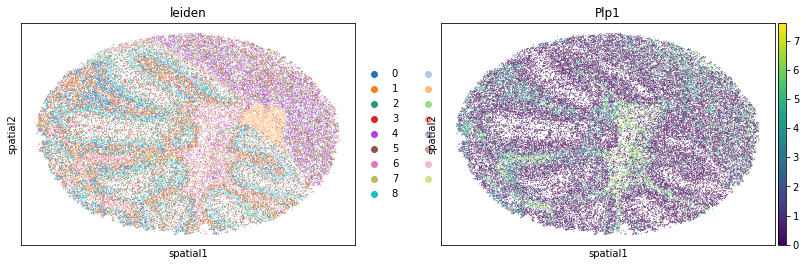

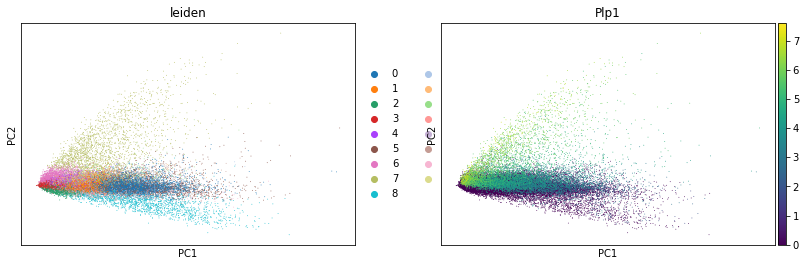

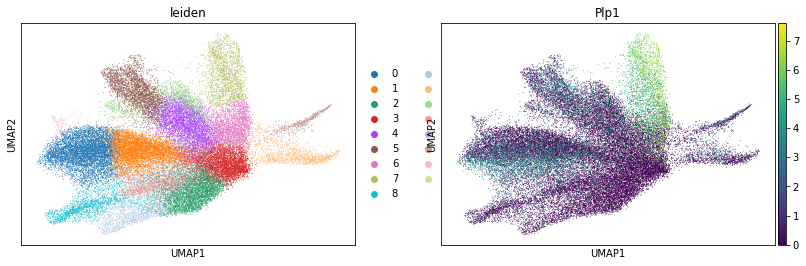

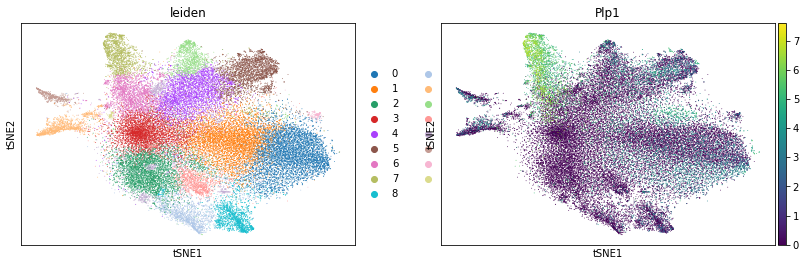

In [21]:
sc.pl.embedding(adata, basis="spatial", color=['leiden', 'Plp1'])
sc.pl.pca(adata, color=['leiden', 'Plp1'])
sc.pl.umap(adata, color=['leiden', 'Plp1'])
sc.pl.tsne(adata, color=['leiden', 'Plp1'])

#### Plotting marker genes to check the quality and annotate the clustering

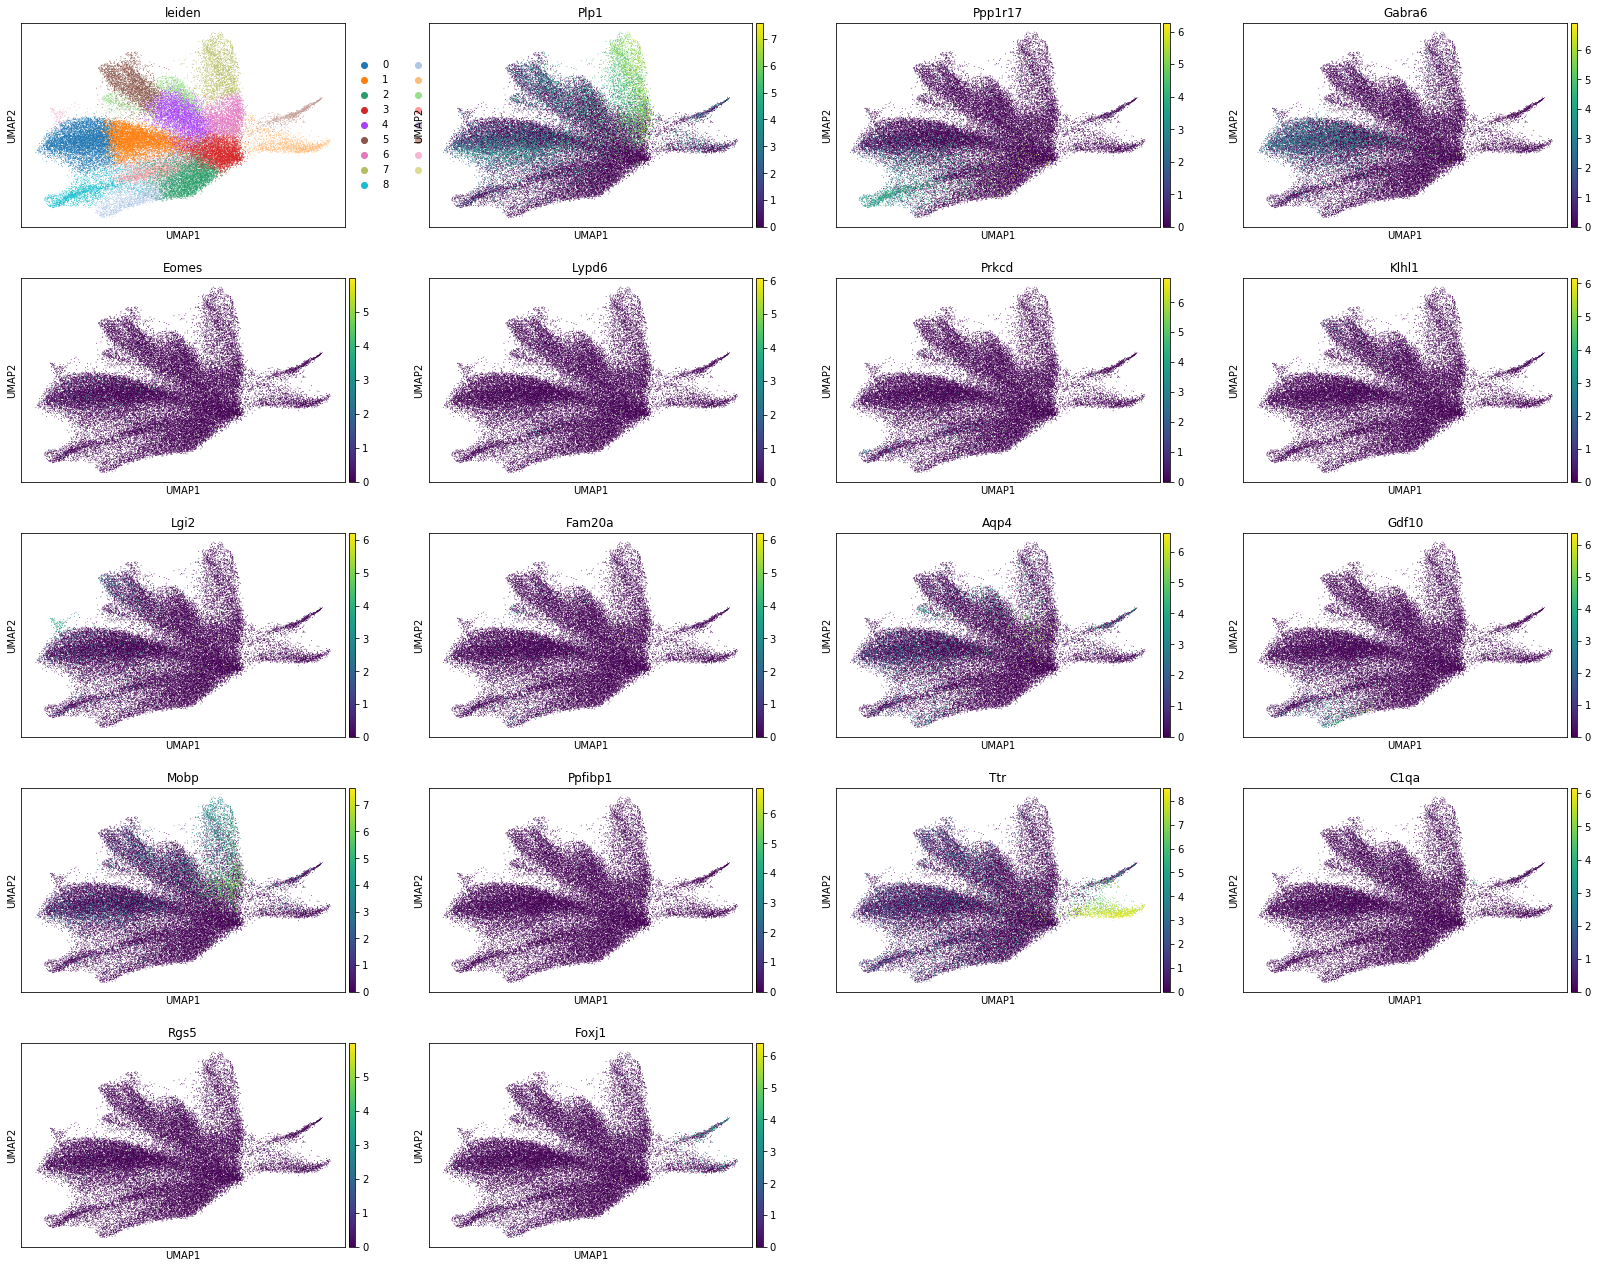

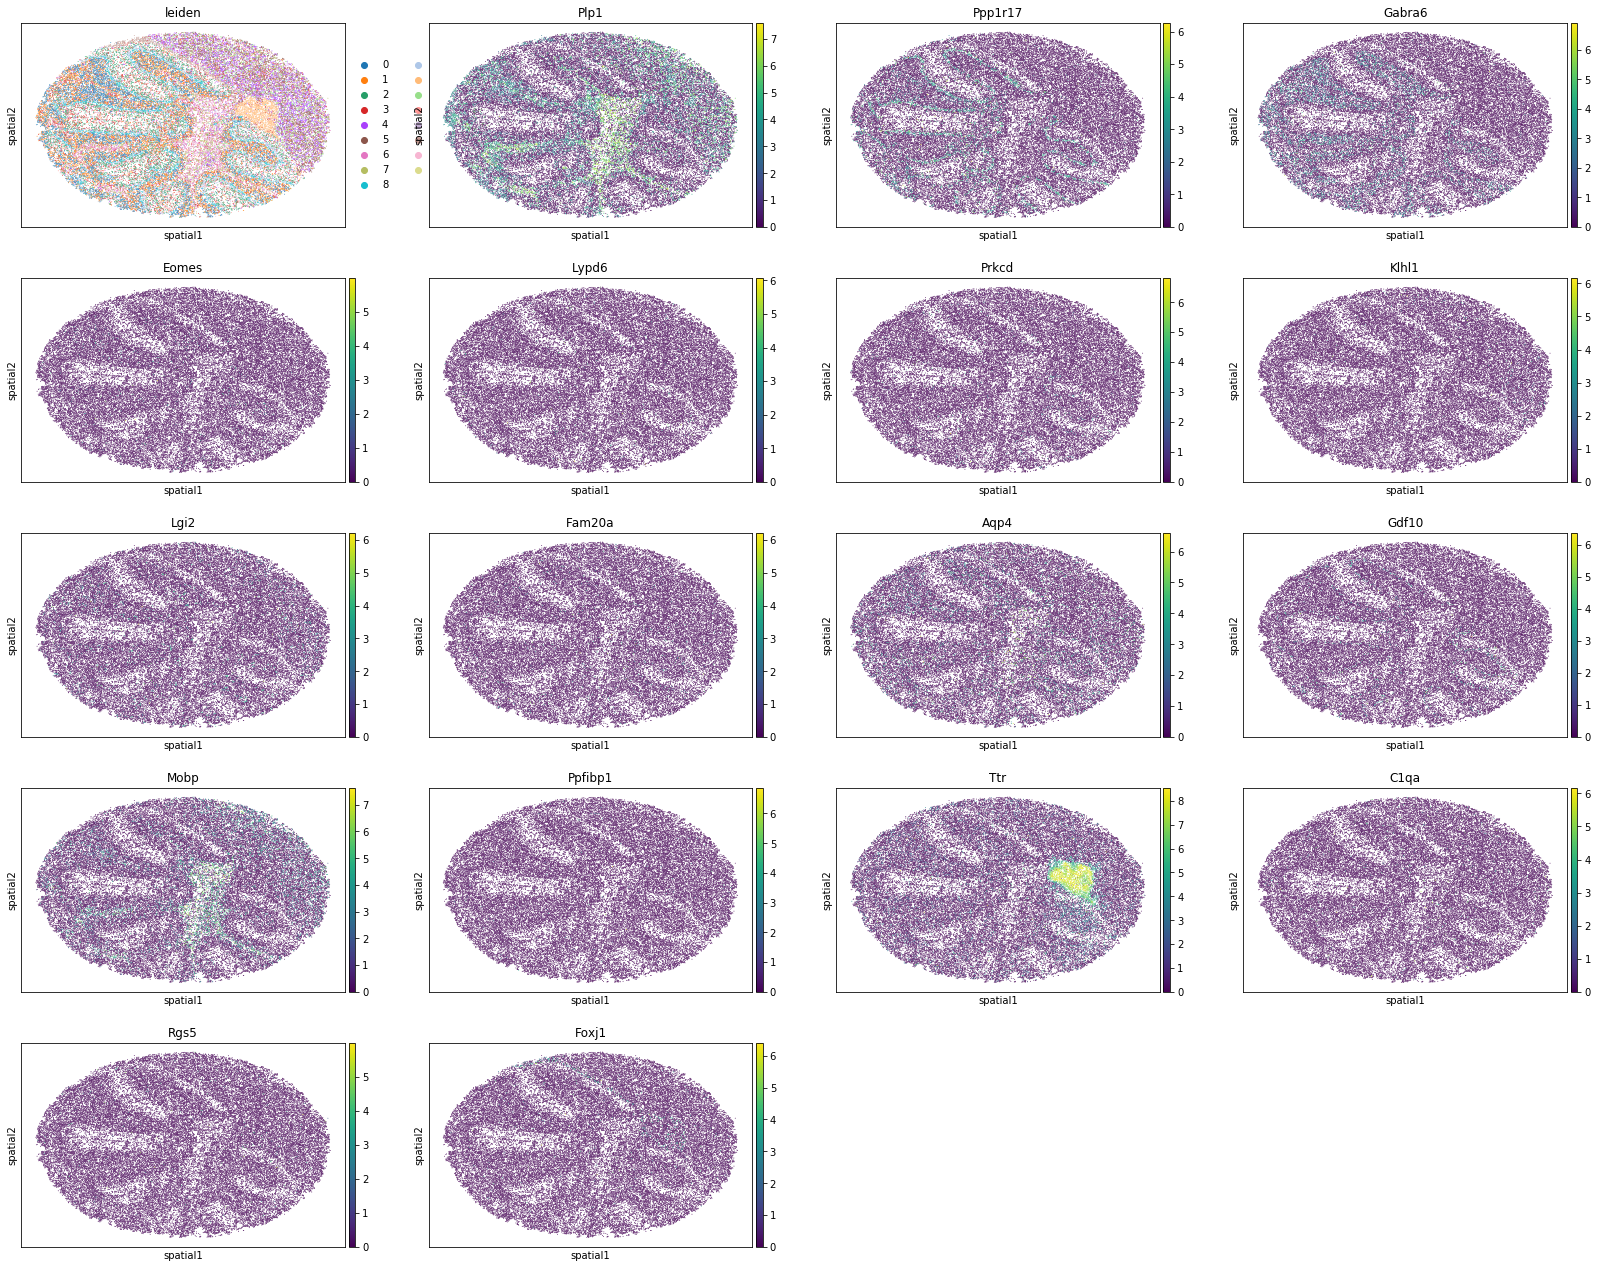

In [22]:
color_vec = ['leiden', 'Plp1', 'Ppp1r17', 'Gabra6',
                             'Eomes', 'Lypd6', 'Prkcd', 'Klhl1',
                             'Lgi2', 'Fam20a', 'Aqp4', 'Gdf10', 'Mobp',
                             'Ppfibp1', 'Ttr', 'C1qa', 'Rgs5', 'Foxj1']
sc.pl.umap(adata, color=color_vec)
sc.pl.embedding(adata, basis="spatial", color=color_vec)

## Interactive plots -- function definitions

In [23]:
def make_vis_df(adata=adata):
    vis_df = pd.DataFrame()
    vis_df['X_spatial'] = adata.obsm['X_spatial'][:,0]
    vis_df['Y_spatial'] = adata.obsm['X_spatial'][:,1]
    vis_df['X_umap'] = adata.obsm['X_umap'][:,0]
    vis_df['Y_umap'] = adata.obsm['X_umap'][:,1]
    vis_df['X_tsne'] = adata.obsm['X_tsne'][:,0]
    vis_df['Y_tsne'] = adata.obsm['X_tsne'][:,1]
    vis_df['X_pca'] = adata.obsm['X_pca'][:,0]
    vis_df['Y_pca'] = adata.obsm['X_pca'][:,1]
    vis_df['index'] = vis_df.index
    vis_df['leiden'] = adata.obs['leiden'].values
    
    return vis_df

In [24]:
def plot_interactive_legend_altair(left_plot, right_plot, mark_size):
    plot_size = 340
    vis_df = make_vis_df(adata=adata)

    zoom = alt.selection_interval(bind='scales')#, translate='')
    legend_selection = alt.selection_multi(fields=['leiden'], bind='legend')
    color_leiden = alt.Color('leiden:N', scale=alt.Scale(scheme='category20b'))
    # Scatter plot panel encoding
    points = alt.Chart(vis_df).mark_circle(
            size=mark_size
    ).encode(
            color = color_leiden,
            opacity=alt.condition(legend_selection, alt.value(1), alt.value(0.1)),
            tooltip=alt.Tooltip('index')
    ).add_selection(
            legend_selection, zoom
    ).properties(
            width=plot_size, height=plot_size
    )

    left_plot = points.encode(x=alt.X('X_'+f'{left_plot}:Q'), y=alt.Y('Y_'+f'{left_plot}:Q'))
    right_plot = points.encode(x=alt.X('X_'+f'{right_plot}:Q'), y=alt.Y('Y_'+f'{right_plot}:Q'))

    final = alt.vconcat(left_plot | right_plot, 
                        title='Scroll to zoom in and out, drag for panning, hover over a dot for info.'+
                        ' Click on a cluster in the legend to highlight it on both plots.')
    return final

In [25]:
def plot_gene_altair(gene, binary_expression, 
                     left_plot, right_plot,
                     mark_size, gene_lower_thresh):
    plot_size = 340
    vis_df = make_vis_df(adata=adata)
    vis_df['gene_count'] = counts[gene].values
    vis_df = vis_df[vis_df['gene_count']>gene_lower_thresh]

    zoom = alt.selection_interval(bind='scales', translate='')
    brush = alt.selection_interval(encodings=['x', 'y'])
    color_gene = alt.Color('gene:N')
    color_leiden = alt.Color('leiden:N', scale=alt.Scale(scheme='category20b'))
    opacity = not binary_expression
    opacity_checkbox = alt.binding_checkbox()
    opacity_selection = alt.selection_single(bind=opacity_checkbox, name='Opacity')
    opacity_off = alt.value(1)
    opacity_on = alt.Opacity('gene_count:Q', scale=alt.Scale(range=(0, 1)))
    opacity = opacity_on if opacity==1 else opacity_off
    # Scatter plot panel encoding
    points = alt.Chart(vis_df).mark_circle(
            size=mark_size # maybe could figure out a way to bind it to the scale
    ).encode(
            color=alt.condition(brush, color_leiden, alt.value('black')),
            opacity=opacity,
            tooltip=['index', 'leiden', 'gene_count']
    ).add_selection(
            zoom, brush
    ).properties(
            width=plot_size, height=plot_size
    )
    # Bar plot panel
    bars = alt.Chart(vis_df).mark_bar().encode(
        x='count()',
        y='leiden:N',
        color='leiden',
        opacity=opacity
    ).transform_filter(
        brush
    ).properties(
        width=plot_size/4, height=plot_size
    )
    
    left_plot = points.encode(x=alt.X('X_'+f'{left_plot}:Q'), y=alt.Y('Y_'+f'{left_plot}:Q'))
    right_plot = points.encode(x=alt.X('X_'+f'{right_plot}:Q'), y=alt.Y('Y_'+f'{right_plot}:Q'))
    
    final = alt.vconcat(left_plot | right_plot | bars,
                        title='Scroll to zoom in and out, hover over a dot for info.'+
                        ' Click and drag to select rectangular area that is tied to the bar plot.')
    return final

In [68]:
def plot_gene_link_selection_altair(gene, 
                                    left_plot, right_plot,
                                    mark_size, gene_lower_thresh):
    plot_size = 340
    vis_df = make_vis_df(adata=adata)
    vis_df['gene_count'] = counts[gene].values
    vis_df = vis_df[vis_df['gene_count']>gene_lower_thresh]
    
    zoom = alt.selection_interval(bind='scales')#, translate='')
    color_leiden = alt.Color('leiden:N', scale=alt.Scale(scheme='category20b'))
    hover = alt.selection_single(resolve='global', on='mouseover', nearest=True, empty='none')
    click = alt.selection_multi(empty='none', resolve='global')
    # Scatter plot panel encodings
    plot = alt.Chart(vis_df).mark_circle().encode()
    base = plot.transform_filter({'or':[hover, click]})

    points = alt.layer(
        plot.add_selection(hover).add_selection(click),
        plot.encode(color=color_leiden),
        base.mark_point(size=1.5*mark_size, stroke='firebrick', strokeWidth=1),
        base.mark_text(dx=4, dy=-8, align='right', stroke='white', strokeWidth=1).encode(text='index'),
        base.mark_text(dx=4, dy=-8, align='right').encode(text='index'),
    ).encode(size=alt.value(mark_size)
    ).add_selection(
            zoom
    ).properties(
            width=plot_size, height=plot_size
    )
    
    left_plot = points.encode(x=alt.X('X_'+f'{left_plot}:Q'), y=alt.Y('Y_'+f'{left_plot}:Q'))
    right_plot = points.encode(x=alt.X('X_'+f'{right_plot}:Q'), y=alt.Y('Y_'+f'{right_plot}:Q'))
    
    final = alt.vconcat(left_plot | right_plot ,
                        title='Scroll to zoom in and out, drag for panning, hover over a dot for info.'+
                        ' Shift+click on points to highlight them on both plots.')
    return final

# Slide-seq plots

In [42]:
left_plot = {'spatial':'spatial', 'umap':'umap', 'tsne':'tsne', 'pca':'pca'}
right_plot = {'umap':'umap', 'tsne':'tsne', 'pca':'pca', 'spatial':'spatial'}

## In examining the clustering it is useful to be able to interactivelly go back and forth between highlighting different clusters, across multiple 2D representations of the data.

In [46]:
print(color.BOLD + 'Use the dropdown menus to select 2D representations.' +
      '\n'+ 'Use the mark_size slider to change the dot size.' + color.END)
interactive_legend_plot = interact(plot_interactive_legend_altair, 
                                   left_plot=left_plot,
                                   right_plot=right_plot,
                                   mark_size=IntSlider(min=4, max=50, step=1, 
                                                       continuous_update=False))

Use the dropdown menus to select 2D representations.
Use the mark_size slider to change the dot size.


interactive(children=(Dropdown(description='left_plot', options={'spatial': 'spatial', 'umap': 'umap', 'tsne':…

## Additionally, it is useful to overlay the expression of known marker genes with the cluster labels.

Define a dictionary of celltypes and their marker genes. This list is from a [recent cerebellum single nucleus study](https://www.biorxiv.org/content/10.1101/2020.03.04.976407v1). 

In [47]:
celltype_markers_dict = {'Purkinje: Ppp1r17':'Ppp1r17',
                         'Granule: Gabra6':'Gabra6',
                         'UBC: Eomes':'Eomes',
                         'MLI1: Lypd6':'Lypd6',
                         'MLI1/MLI2: Prkcd':'Prkcd',
                         'PLI: Klhl1':'Klhl1',
                         'Golgi: Lgi2':'Lgi2',
                         'Bergmann: Gdf10':'Gdf10',
                         'Astrocyte: Aqp4':'Aqp4',
                         'ODC: Mobp':'Mobp',
                         'OPC: Ppfibp1':'Ppfibp1',
                         'Fibroblast: Dcn':'Dcn',
                         'Endothelial mural: Kcnj8':'Kcnj8',
                         'Choroid: Ttr':'Ttr',
                         'Macrophage: Mrc1':'Mrc1',
                         'Microglia/Macrophage: C1qa':'C1qa',
                         'Endothelial stalk: Flt1':'Flt1',
                         'Ependymal: Foxj1':'Foxj1'}

In [48]:
print(color.BOLD + 'Use the first dropdown menu to select a marker gene for a given celltype.' +
      '\n'+ 'Use the checkbox to toggle between binary and proportional to gene expression color strength.' +
      '\n'+ 'Use the dropdown menus to select 2D representations.' +
      '\n'+ 'Use the mark_size slider to change the dot size.' +
      '\n'+ 'Use the gene_lower_bound slider to filter by gene expression above the selected value.' + color.END +
      '\n'+ 'Note: mark_size and gene_lower_thresh min and max bounds are easily modifiable from the function call above.')
celltype_marker_plot = interact(plot_gene_altair, 
                                gene=celltype_markers_dict, 
                                left_plot=left_plot,
                                right_plot=right_plot,
                                binary_expression=False,
                                mark_size=IntSlider(min=6, max=50, step=1, 
                                                    continuous_update=False),
                                gene_lower_thresh=IntSlider(min=0, max=10, step=1, 
                                                            continuous_update=False))

Use the first dropdown menu to select a marker gene for a given celltype.
Use the checkbox to toggle between binary and proportional to gene expression color strength.
Use the dropdown menus to select 2D representations.
Use the mark_size slider to change the dot size.
Use the gene_lower_bound slider to filter by gene expression above the selected value.
Note: mark_size and gene_lower_thresh min and max bounds are easily modifiable from the function call above.


interactive(children=(Dropdown(description='gene', options={'Purkinje: Ppp1r17': 'Ppp1r17', 'Granule: Gabra6':…

## We can type in any valid gene name and overlay its expression with the cluster labels.

In [30]:
print(color.BOLD + 'Enter a gene name of your choice in the text box. For example, try Ttr, Slc1a3, or Gabra6.' +
      '\n'+ 'Use the checkbox to toggle between binary and proportional to gene expression color strength.' +
      '\n'+ 'Use the dropdown menus to select 2D representations.' +
      '\n'+ 'Use the mark_size slider to change the dot size.' +
      '\n'+ 'Use the gene_lower_bound slider to filter by gene expression above the selected value.' + color.END +
      '\n'+ 'Note: mark_size and gene_lower_thresh min and max bounds are easily modifiable from the function call above.')
gene_name_plot = interact(plot_gene_altair, 
                          gene='Aldoc', 
                          left_plot=left_plot,
                          right_plot=right_plot,
                          binary_expression=False,
                          mark_size=IntSlider(min=6, max=50, step=1, 
                                              continuous_update=False),
                          gene_lower_thresh=IntSlider(min=0, max=10, step=1, 
                                                      continuous_update=False))

Enter a gene name of your choice in the text box. For example, try Ttr, Slc1a3, or Gabra6.
Use the checkbox to toggle between binary and proportional to gene expression color strength.
Use the dropdown menus to select 2D representations.
Use the mark_size slider to change the dot size.
Use the gene_lower_bound slider to filter by gene expression above the selected value.
Note: mark_size and gene_lower_thresh min and max bounds are easily modifiable from the function call above.


interactive(children=(Text(value='Aldoc', description='gene'), Checkbox(value=False, description='binary_expre…

## Or we can define a list of genes of interest:

Define a list of genes of interest below:

In [54]:
gene_list = ['Foxj1', 'Rasgrf1', 'Mybpc1', 'Wif1', 'Aqp4']

In [55]:
print(color.BOLD + 'Choose a gene from the dropdown menu.' +
      '\n'+ 'Use the checkbox to toggle between binary and proportional to gene expression color strength.' +
      '\n'+ 'Use the dropdown menus to select 2D representations.' +
      '\n'+ 'Use the mark_size slider to change the dot size.' +
      '\n'+ 'Use the gene_lower_bound slider to filter by gene expression above the selected value.' + color.END +
      '\n'+ 'Note: mark_size and gene_lower_thresh min and max bounds are easily modifiable from the function call above.')
gene_name_plot = interact(plot_gene_altair, 
                          gene=gene_list, 
                          left_plot=left_plot,
                          right_plot=right_plot,
                          binary_expression=False,
                          mark_size=IntSlider(min=6, max=50, step=1, 
                                              continuous_update=False),
                          gene_lower_thresh=IntSlider(min=0, max=10, step=1, 
                                                      continuous_update=False))

Choose a gene from the dropdown menu.
Use the checkbox to toggle between binary and proportional to gene expression color strength.
Use the dropdown menus to select 2D representations.
Use the mark_size slider to change the dot size.
Use the gene_lower_bound slider to filter by gene expression above the selected value.
Note: mark_size and gene_lower_thresh min and max bounds are easily modifiable from the function call above.


interactive(children=(Dropdown(description='gene', options=('Foxj1', 'Rasgrf1', 'Mybpc1', 'Wif1', 'Aqp4'), val…

## Link the selection of points across the two plots:

In [71]:
print(color.BOLD + 'Choose a gene from the dropdown menu.' +
      '\n'+ 'Use the dropdown menus to select 2D representations.' +
      '\n'+ 'Use the mark_size slider to change the dot size.' +
      '\n'+ 'Use the gene_lower_bound slider to filter by gene expression above the selected value.' + color.END +
      '\n'+ 'Note: mark_size and gene_lower_thresh min and max bounds are easily modifiable from the function call above.')
gene_link_selection_plot = interact(plot_gene_link_selection_altair, 
                                    gene=gene_list, 
                                    left_plot=left_plot,
                                    right_plot=right_plot,
                                    mark_size=IntSlider(min=6, max=50, step=1, 
                                                        continuous_update=False),
                                    gene_lower_thresh=IntSlider(min=0, max=10, step=1, 
                                                                continuous_update=False))

Choose a gene from the dropdown menu.
Use the dropdown menus to select 2D representations.
Use the mark_size slider to change the dot size.
Use the gene_lower_bound slider to filter by gene expression above the selected value.
Note: mark_size and gene_lower_thresh min and max bounds are easily modifiable from the function call above.


interactive(children=(Dropdown(description='gene', options=('Foxj1', 'Rasgrf1', 'Mybpc1', 'Wif1', 'Aqp4'), val…

# Single cell RNAseq data

The same type of plots are also useful for single cell RNAseq data. In order to illustrate this point without having to load a new dataset, below we pretend that the data from Slide-seq Puck_190926_11 is not spatial, but single cell; i.e. each bead is a cell withou spatial coordinates.

In [72]:
left_plot = {'tsne':'tsne', 'pca':'pca', 'umap':'umap'}
right_plot = {'umap':'umap', 'tsne':'tsne', 'pca':'pca'}

In [73]:
print(color.BOLD + 'Use the dropdown menus to select 2D representations.' +
      '\n'+ 'Use the mark_size slider to change the dot size.' + color.END)
interactive_legend_plot = interact(plot_interactive_legend_altair, 
                                   left_plot=left_plot,
                                   right_plot=right_plot,
                                   mark_size=IntSlider(min=4, max=50, step=1, 
                                                       continuous_update=False))

Use the dropdown menus to select 2D representations.
Use the mark_size slider to change the dot size.


interactive(children=(Dropdown(description='left_plot', options={'tsne': 'tsne', 'pca': 'pca', 'umap': 'umap'}…

In [74]:
print(color.BOLD + 'Use the first dropdown menu to select a marker gene for a given celltype.' +
      '\n'+ 'Use the checkbox to toggle between binary and proportional to gene expression color strength.' +
      '\n'+ 'Use the dropdown menus to select 2D representations.' +
      '\n'+ 'Use the mark_size slider to change the dot size.' +
      '\n'+ 'Use the gene_lower_bound slider to filter by gene expression above the selected value.' + color.END +
      '\n'+ 'Note: mark_size and gene_lower_thresh min and max bounds are easily modifiable from the function call above.')
celltype_marker_plot = interact(plot_gene_altair, 
                                gene=celltype_markers_dict, 
                                left_plot=left_plot,
                                right_plot=right_plot,
                                binary_expression=False,
                                mark_size=IntSlider(min=6, max=50, step=1, 
                                                    continuous_update=False),
                                gene_lower_thresh=IntSlider(min=0, max=10, step=1, 
                                                            continuous_update=False))

Use the first dropdown menu to select a marker gene for a given celltype.
Use the checkbox to toggle between binary and proportional to gene expression color strength.
Use the dropdown menus to select 2D representations.
Use the mark_size slider to change the dot size.
Use the gene_lower_bound slider to filter by gene expression above the selected value.
Note: mark_size and gene_lower_thresh min and max bounds are easily modifiable from the function call above.


interactive(children=(Dropdown(description='gene', options={'Purkinje: Ppp1r17': 'Ppp1r17', 'Granule: Gabra6':…

In [75]:
print(color.BOLD + 'Enter a gene name of your choice in the text box.' +
      '\n'+ 'Use the checkbox to toggle between binary and proportional to gene expression color strength.' +
      '\n'+ 'Use the dropdown menus to select 2D representations.' +
      '\n'+ 'Use the mark_size slider to change the dot size.' +
      '\n'+ 'Use the gene_lower_bound slider to filter by gene expression above the selected value.' + color.END +
      '\n'+ 'Note: mark_size and gene_lower_thresh min and max bounds are easily modifiable from the function call above.')

gene_name_plot = interact(plot_gene_altair, 
                          gene='Aldoc', 
                          left_plot=left_plot,
                          right_plot=right_plot,
                          binary_expression=False,
                          mark_size=IntSlider(min=6, max=50, step=1, 
                                              continuous_update=False),
                          gene_lower_thresh=IntSlider(min=0, max=10, step=1, 
                                                      continuous_update=False))

Enter a gene name of your choice in the text box.
Use the checkbox to toggle between binary and proportional to gene expression color strength.
Use the dropdown menus to select 2D representations.
Use the mark_size slider to change the dot size.
Use the gene_lower_bound slider to filter by gene expression above the selected value.
Note: mark_size and gene_lower_thresh min and max bounds are easily modifiable from the function call above.


interactive(children=(Text(value='Aldoc', description='gene'), Checkbox(value=False, description='binary_expre…

Define a list of genes of interest below:

In [76]:
gene_list = ['Rasgrf1', 'Mybpc1', 'Wif1', 'Aqp4']

In [77]:
print(color.BOLD + 'Choose a gene from the dropdown menu.' +
      '\n'+ 'Use the checkbox to toggle between binary and proportional to gene expression color strength.' +
      '\n'+ 'Use the dropdown menus to select 2D representations.' +
      '\n'+ 'Use the mark_size slider to change the dot size.' +
      '\n'+ 'Use the gene_lower_bound slider to filter by gene expression above the selected value.' + color.END +
      '\n'+ 'Note: mark_size and gene_lower_thresh min and max bounds are easily modifiable from the function call above.')
gene_name_plot = interact(plot_gene_altair, 
                          gene=gene_list, 
                          left_plot=left_plot,
                          right_plot=right_plot,
                          binary_expression=False,
                          mark_size=IntSlider(min=6, max=50, step=1, 
                                              continuous_update=False),
                          gene_lower_thresh=IntSlider(min=0, max=10, step=1, 
                                                      continuous_update=False))

Choose a gene from the dropdown menu.
Use the checkbox to toggle between binary and proportional to gene expression color strength.
Use the dropdown menus to select 2D representations.
Use the mark_size slider to change the dot size.
Use the gene_lower_bound slider to filter by gene expression above the selected value.
Note: mark_size and gene_lower_thresh min and max bounds are easily modifiable from the function call above.


interactive(children=(Dropdown(description='gene', options=('Rasgrf1', 'Mybpc1', 'Wif1', 'Aqp4'), value='Rasgr…

In [ ]:
print(color.BOLD + 'Choose a gene from the dropdown menu.' +
      '\n'+ 'Use the dropdown menus to select 2D representations.' +
      '\n'+ 'Use the mark_size slider to change the dot size.' +
      '\n'+ 'Use the gene_lower_bound slider to filter by gene expression above the selected value.' + color.END +
      '\n'+ 'Note: mark_size and gene_lower_thresh min and max bounds are easily modifiable from the function call above.')
gene_link_selection_plot = interact(plot_gene_link_selection_altair, 
                                    gene=gene_list, 
                                    left_plot=left_plot,
                                    right_plot=right_plot,
                                    mark_size=IntSlider(min=6, max=50, step=1, 
                                                        continuous_update=False),
                                    gene_lower_thresh=IntSlider(min=0, max=10, step=1, 
                                                                continuous_update=False))

## It is easy to extend these interactive visualizations to multiple datasets shown side by side.

In [ ]:
import gc
gc.collect()